In [1]:
%matplotlib inline
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from __future__ import print_function

# turn of data table rendering
pd.set_option('display.notebook_repr_html', False)
sns.set_palette(['#00A99D', '#F5CA0C', '#B6129F', '#76620C', '#095C57'])
sys.version

'3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]'

## Support Vector Machines
Support Vector Machines, or SVMs, are supervised learning models used for classification and regression analysis. The concept of how SVMs work can be hard to grasp. It sure is a much more advanced way to classify data than the [Naive Bayes](http://unsupervised-learning.com/gaussian-naive-bayes-classifier-scikit-learn/) algorithm discussed earlier. Given a data set with features and classes, an SVM finds a line with the largest distance between each of two features, called an optimal hyperplane with a maximal margin. It's like a highway through the data points separating the two features as much as possible.

The plot shown below, borrowed from the [scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#example-svm-plot-separating-hyperplane-py), shows a linear SVM hyperplane on two features with three support vectors in yellow.

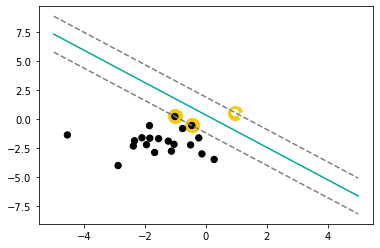

In [2]:
# We create 40 separable points
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [0] * 20 + [1] * 20

# Fit the model
clf = SVC(kernel='linear')
clf.fit(X, Y)

# Get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

# Plot the parallels to the separating hyperplane that pass through the
# support vectors
b = clf.support_vectors_[0]
yy_down = a * xx + (b[1] - a * b[0])
b = clf.support_vectors_[-1]
yy_up = a * xx + (b[1] - a * b[0])

# Plot the line, the points, and the nearest vectors to the plane
plt.plot(xx, yy, 'k-', color='#00A99D')
plt.plot(xx, yy_down, 'k--', color='gray')
plt.plot(xx, yy_up, 'k--', color='gray')

# Plot the support vectors in yellow
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, color='#F5CA0C')
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='gray', s=40)
plt.show()

## Kernel functions
The example here uses a linear kernel function. Applied to the features it makes the data highly separable by increasing the dimensionality of the data. The scikit-learn SVM implementation had three [built-in kernel functions](http://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html) 'linear', 'poly' and 'rbf'.

## Example
In this example we use an SVM with a linear kernel to predict who wrote an update on Twitter. The dataset contains recent tweets of two data analytics giants; Gregory Piatetsky ([@kdnuggets](https://twitter.com/kdnuggets)) and Big Data Science ([@analyticbridge](https://twitter.com/analyticbridge)). The screen_name acts as the label while each word in the tweet is a feature.

You can [download the data set](https://raw.githubusercontent.com/remondo/NoteBooks-Unsupervised-Learning/master/data/tweets.csv) from Github.

In [3]:
# Load 200 tweets from @kdnuggets and @analyticbridge (n=400)
df = pd.read_csv('data/tweets.csv')
df.screen_name.value_counts()

analyticbridge    200
kdnuggets         200
Name: screen_name, dtype: int64

In [4]:
# Show arbitrary datapoint
df.screen_name[331], df.tweet[331]

('analyticbridge',
 'Three myths about data scientists and big data http://t.co/EtzjR4pdbH')

In [5]:
# Shuffle the data
def shuffle(data, n):
    ind = data.index
    for i in range(n):
       sampler = np.random.permutation(data.shape[0])
       new_vals = data.take(sampler).values
       data = pd.DataFrame(new_vals, index=ind)
    return data

df = shuffle(df, 1)
df.columns = ['screen_name', 'tweet']
df.head()

      screen_name                                              tweet
0  analyticbridge  Six keywords characterizing milestones in the ...
1       kdnuggets  Get practical training at PASS Business Analyt...
2  analyticbridge  The application of Propensity Score Matching h...
3       kdnuggets  Old data analysts don't die - they just get br...
4       kdnuggets  How Many Quants are Changing Jobs? http://t.co...

## Training and test sets
To train our SVM model, we need a large enough training set and a test set to test for accuracy. We split the data 75% for training and 25% for testing the model.

In [6]:
# Create a training set (3/4 of the data)
train_n = 300
train_features = df['tweet'][:train_n]
train_labels = df['screen_name'][:train_n]
train_features.count()

300

In [7]:
# Create a test set (1/4 of the data)
test_features = df['tweet'][train_n:]
test_labels = df['screen_name'][train_n:]
test_features.count()

100

## TF-IDF Feature Vectors
To extract useful features from the tweets we use the TF-IDF algorithm to qualify the importance of words. For more on TF-IDF, see [Using TF-IDF for Text Mining in Python](http://unsupervised-learning.com/tf-idf-text-mining-python). To do this, we use the [count_vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [tfidf_transformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) from the scikit-learn machine learning library.

In [8]:
# In order to perform machine learning on text documents, we first 
# need to turn the text content into numerical features.
count_vectorizer = CountVectorizer()

train_counts = count_vectorizer.fit_transform(train_features)
train_counts.shape

(300, 1688)

In [9]:
# Transform to Term Frequencies - Inverse Document Frequencies
tfidf_transformer = TfidfTransformer(use_idf=False)
tfidf_transformer.fit(train_counts)

train_tfidf = tfidf_transformer.transform(train_counts)
train_tfidf.shape

(300, 1688)

In [10]:
# Create a TF-IDF for the test data
test_counts = count_vectorizer.transform(test_features)
test_tfidf = tfidf_transformer.transform(test_counts)
test_tfidf.shape

(100, 1688)

## Training the SVM Classifier
We train the Support Vector Machine with a linear kernel on the TF-IDF scores and both Twitter handles as the training labels.

In [11]:
# Train the SVC with linear kernel
clf = SVC(kernel="linear")
clf.fit(train_tfidf, train_labels)

SVC(kernel='linear')

## Prediction
To test our fitted model, we use the test set to predict tweets it has never seen before.

In [12]:
# Predict with the test data
pred = clf.predict(test_tfidf)
pred[:11]

array(['kdnuggets', 'analyticbridge', 'analyticbridge', 'analyticbridge',
       'analyticbridge', 'kdnuggets', 'analyticbridge', 'analyticbridge',
       'kdnuggets', 'kdnuggets', 'kdnuggets'], dtype=object)

## Model Accuracy
We determine the current model accuracy by comparing the actual test labels with the predicted labels.

D:\1\a3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


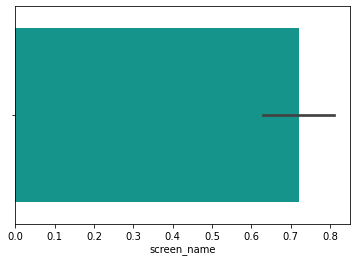

In [13]:
# Plot the accuracy of the model
sns.barplot(test_labels == pred, color='#00A99D')
plt.show()

In [14]:
# Calculate the accuracy
accuracy = accuracy_score(pred, test_labels)
accuracy

0.72

So it works, but the model is not accurate enough. Maybe not that bad since the model is trained on a relatively small dataset.